This tutorial illustrates how to forecast power consumption in Tetuan City given its 10-min time-series data.

Data was taken from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city, which contains the following attributes:

- **Date Time:** Each ten minutes.
- **Temperature:** Weather Temperature of Tetouan city.
- **Humidity:** Weather Humidity of Tetouan city.
- **Wind Speed:** Wind Speed of Tetouan city.
- **general diffuse flows**
- **diffuse flows**
- **Zone 1  Power Consumption:** power consumption of zone 1 of Tetouan city.
- **Zone 2  Power Consumption:** power consumption of zone 2 of Tetouan city.
- **Zone 3  Power Consumption:** power consumption of zone 3 of Tetouan city.

In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

## Constants

In [3]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
WEIGHT_PATH = "weights"

## EDA

In [4]:
power_consumption = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv")

In [5]:
power_consumption.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [6]:
# Standardize column names
cols = power_consumption.columns = power_consumption.columns
cols = ["_".join(col.lower().split()) for col in cols]
power_consumption.columns = cols

In [7]:
# Set datetime as an index for faster querying
df = power_consumption.set_index("datetime")
df.index = pd.to_datetime(df.index)

<AxesSubplot:xlabel='datetime'>

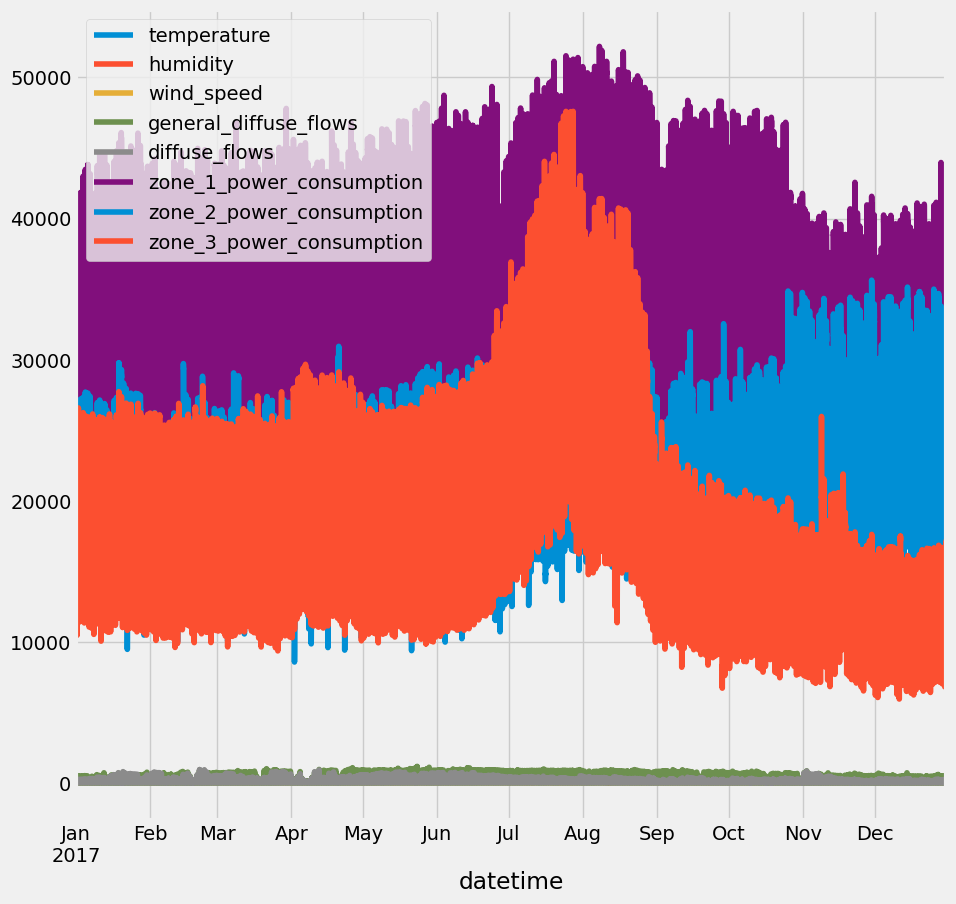

In [8]:
df.plot(figsize=(10,10))

In [9]:
# All of our features are float64, luckily
df.dtypes 

temperature                 float64
humidity                    float64
wind_speed                  float64
general_diffuse_flows       float64
diffuse_flows               float64
zone_1_power_consumption    float64
zone_2_power_consumption    float64
zone_3_power_consumption    float64
dtype: object

In [10]:
# Again, peek into some stats
df.describe()

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power_consumption,zone_2_power_consumption,zone_3_power_consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


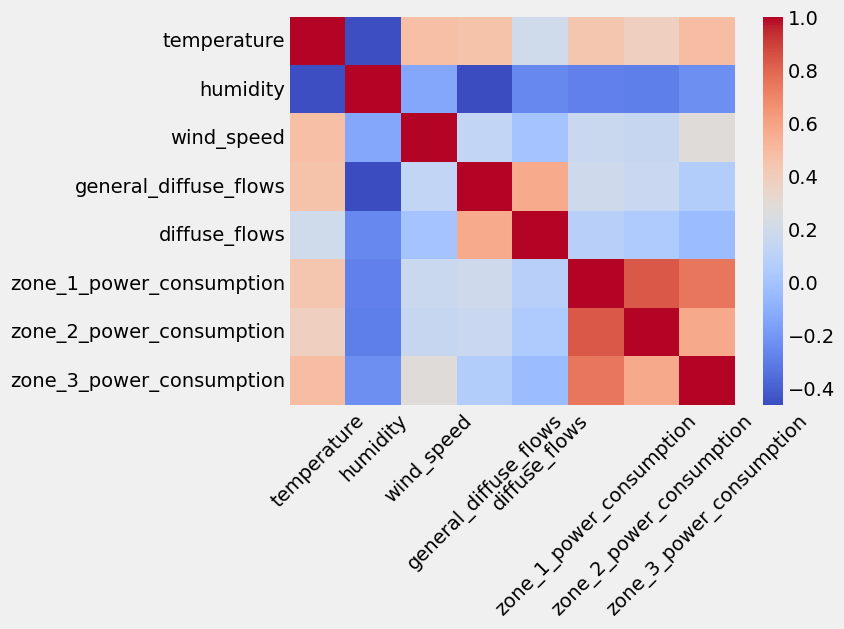

In [11]:
# Correlation matrix to see correlations between features
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')
plt.xticks(rotation=45)
plt.show()

In [12]:
# This idea code is taken from this
# https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
def create_features(df):
    # Extract more features from its time series index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

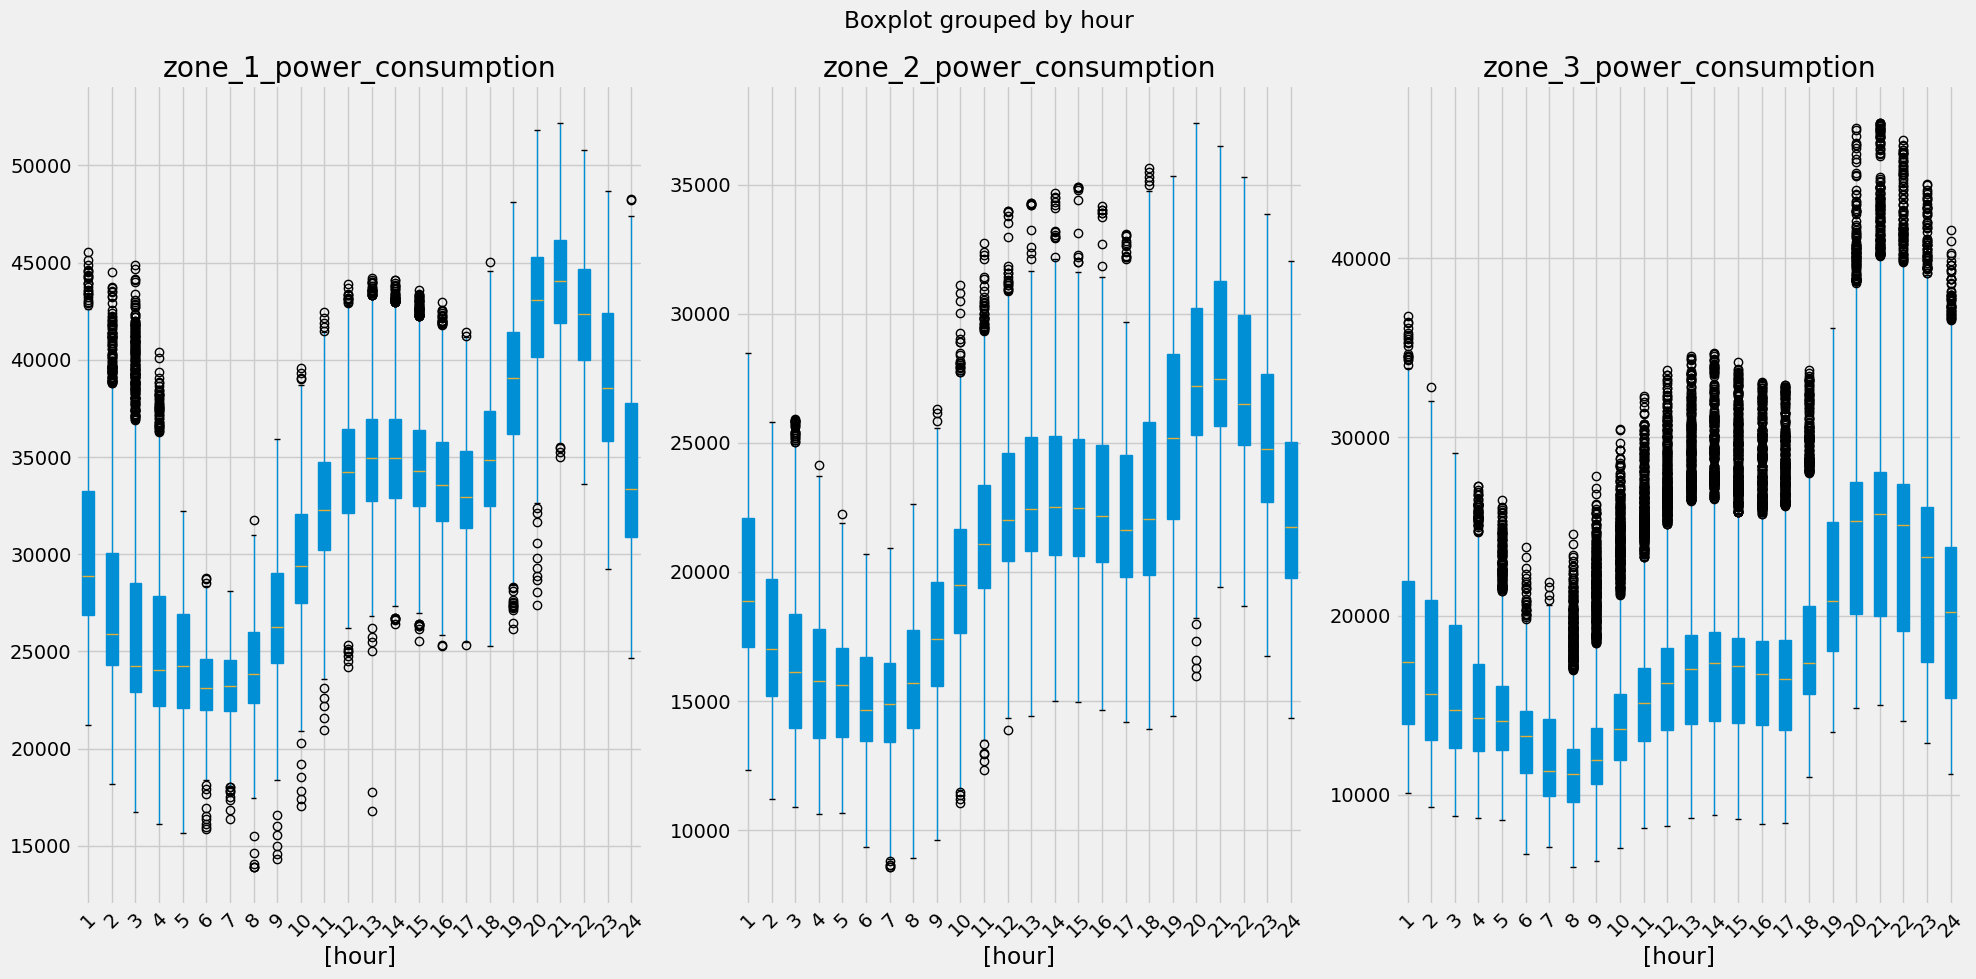

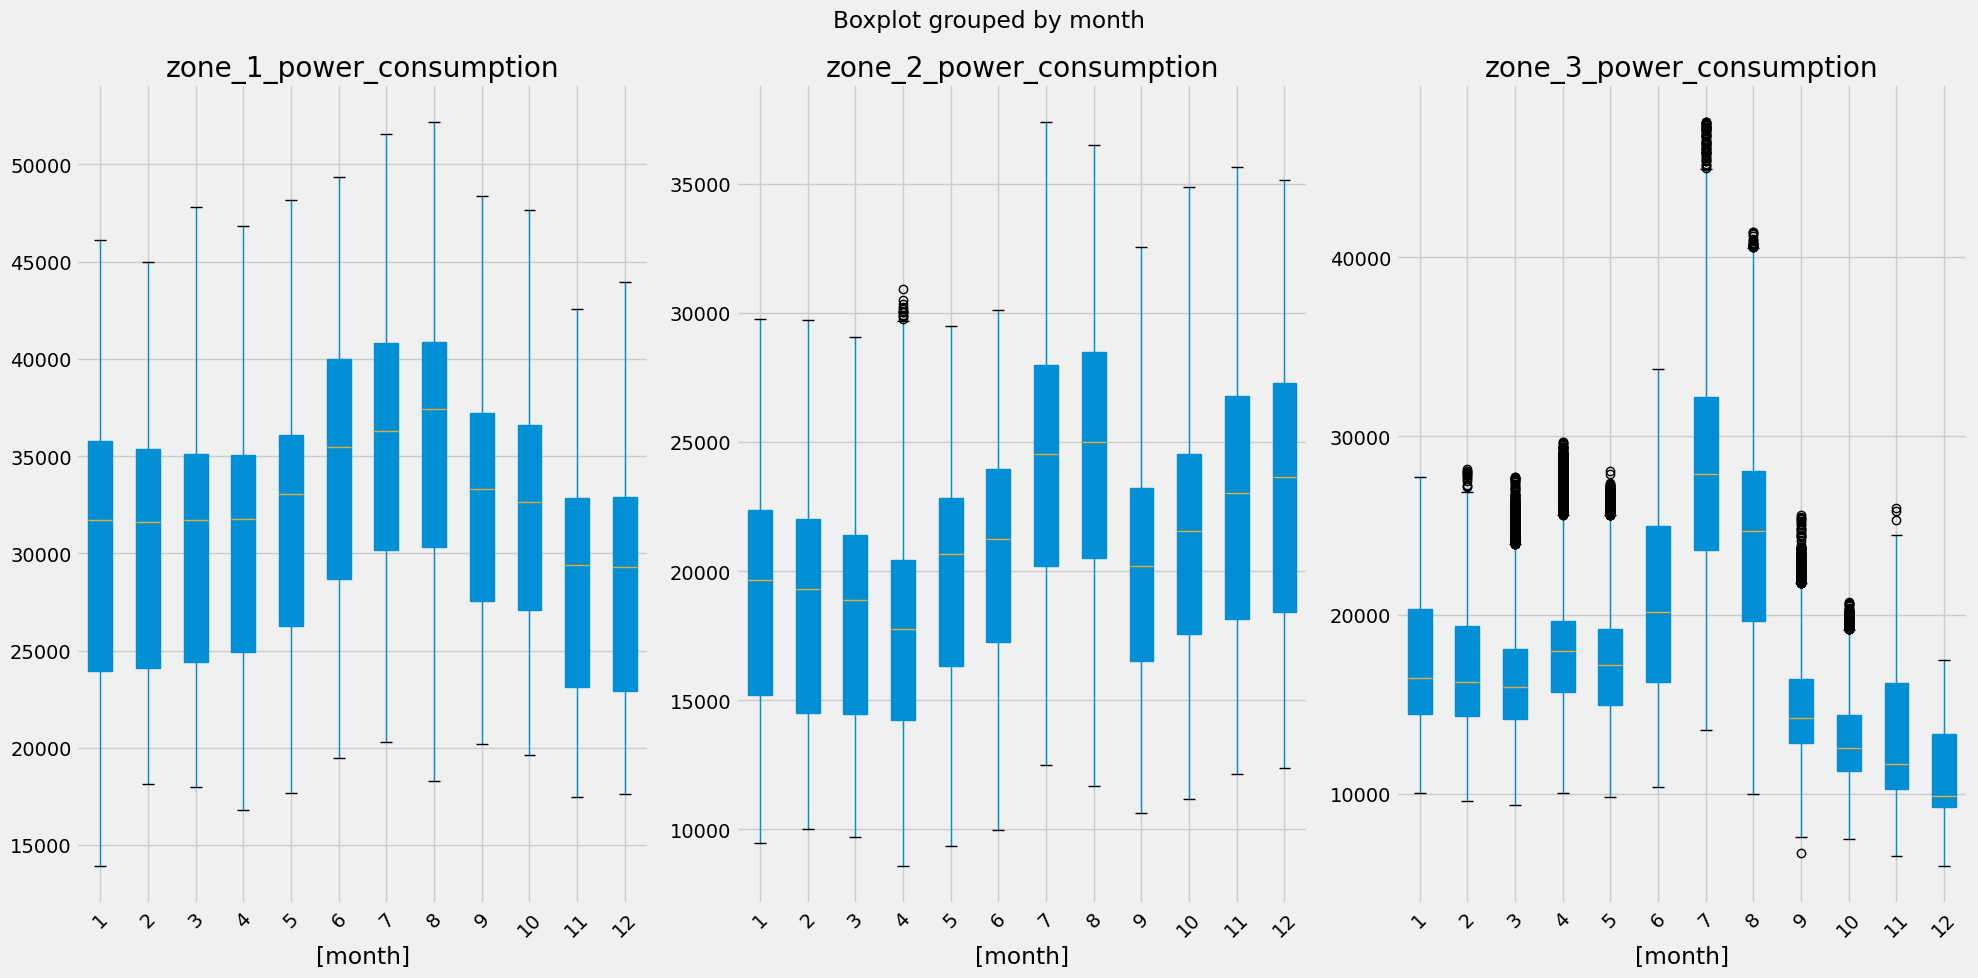

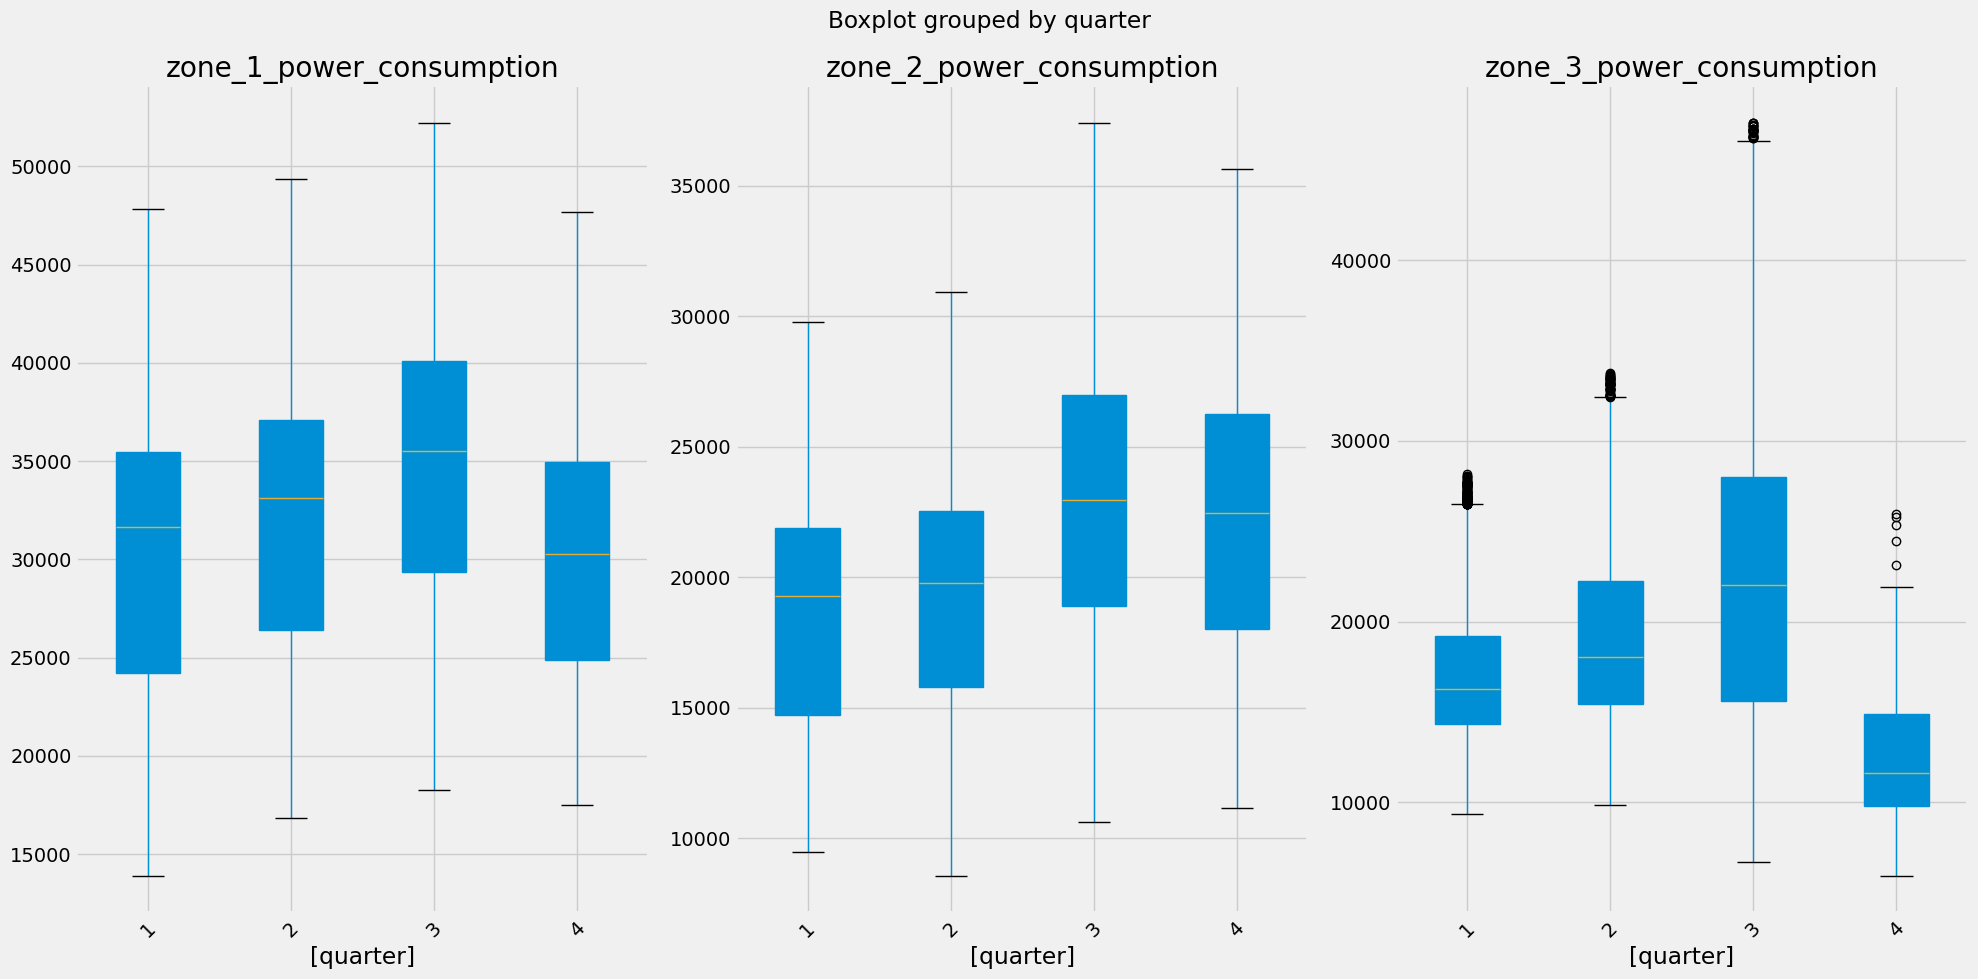

In [13]:
# Visualize 3 zone power consumptions
nrows = 1
ncols = 3

# Loop over each column to plot to subplot
for tr in ["hour", "month", "quarter"]:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), tight_layout=True)
    
    for i in range(ncols):
        col_idx = i
        ax = axes[col_idx]

        col_name = f"zone_{i+1}_power_consumption"
        pd.DataFrame(df[[col_name, tr]]).boxplot(ax=ax, by=tr, patch_artist=True)
        ax.set_title(col_name)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)

We can observe similar patterns in zone 1 and 2. The consumption of zone 3 is much lower.

## Prepare training data

In [14]:
# Set seed all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42)

Train min: 2017-05-02 08:00:00, max: 2017-08-31 15:50:00
Test min: 2017-08-31 16:00:00, max: 2017-12-30 23:50:00


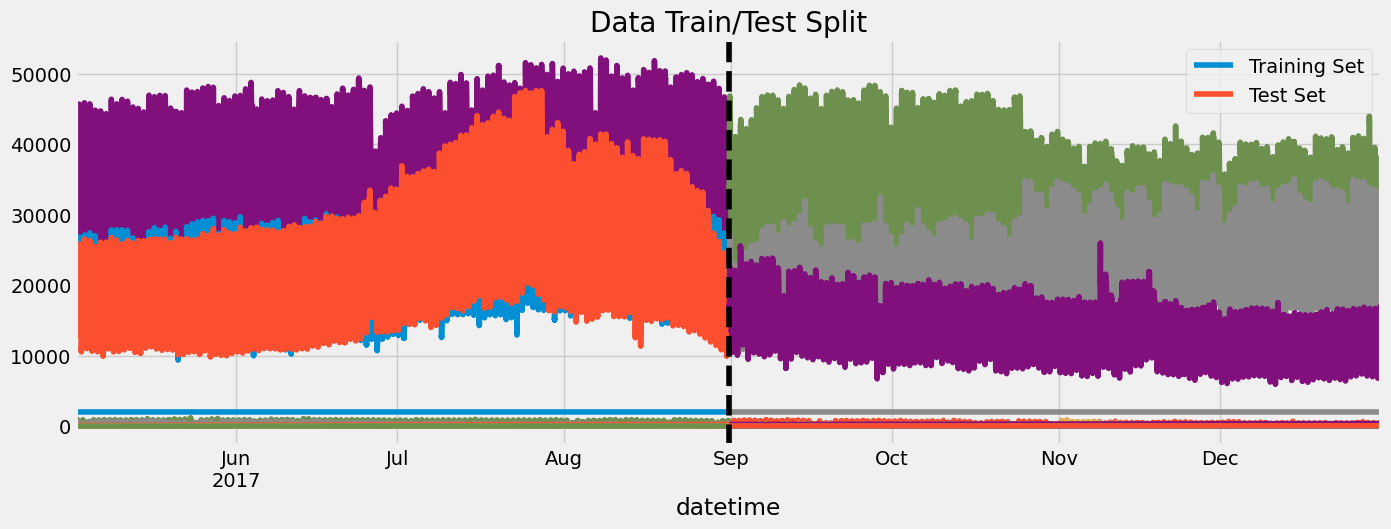

In [15]:
from sklearn.model_selection import TimeSeriesSplit

# Split equally for train and test
# TODO: Please try with a percentage instead, hint: https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split
tss = TimeSeriesSplit(n_splits=2)

# Split by n_splits
train_splits, test_splits = tss.split(df)

# Get indexes belong to train and test
train_split = train_splits[1]
test_split = test_splits[1]

# Get dataframr based on the previous calculated index
train = df.iloc[train_split, :]
test = df.iloc[test_split, :]

# Let's check 
print(f"Train min: {train.index.min()}, max: {train.index.max()}")
print(f"Test min: {test.index.min()}, max: {test.index.max()}")

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test.index.min(), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Training

In [16]:
train = create_features(train)
test = create_features(test)

# Define which columns are features, and which is the target
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'zone_1_power_consumption'

X_train = train[target]
y_train = train[target]

X_test = test[target]
y_test = test[target]

/tmp/ipykernel_37617/2934070059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_37617/2934070059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/tmp/ipykernel_37617/2934070059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [17]:
# Refer to this link
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# or the Kaggle Book for more about hyper-parameter tuning
reg = xgb.XGBRegressor(
    booster='gbtree',    
    n_estimators=1000,
    objective='reg:linear',
    max_depth=6,
    learning_rate=0.01
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:7109.74457	validation_1-rmse:7542.07675
[100]	validation_0-rmse:2612.87291	validation_1-rmse:2779.18505


/home/quandv/anaconda3/envs/poc/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:22:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:961.67232	validation_1-rmse:1030.33707
[300]	validation_0-rmse:357.55709	validation_1-rmse:394.17945
[400]	validation_0-rmse:142.16366	validation_1-rmse:175.25436
[500]	validation_0-rmse:75.29689	validation_1-rmse:114.42105
[600]	validation_0-rmse:60.86667	validation_1-rmse:102.11519
[700]	validation_0-rmse:58.64453	validation_1-rmse:99.79785
[800]	validation_0-rmse:58.33769	validation_1-rmse:99.27670
[900]	validation_0-rmse:58.29611	validation_1-rmse:99.12998
[999]	validation_0-rmse:58.29052	validation_1-rmse:99.08197


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [18]:
# Save model
if not os.path.exists(WEIGHT_PATH):
    os.mkdirs(WEIGHT_PATH)

joblib.dump(reg, os.path.join(WEIGHT_PATH, "model.joblib"))

['weights/model.joblib']

## Forecasting

/tmp/ipykernel_37617/3992132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


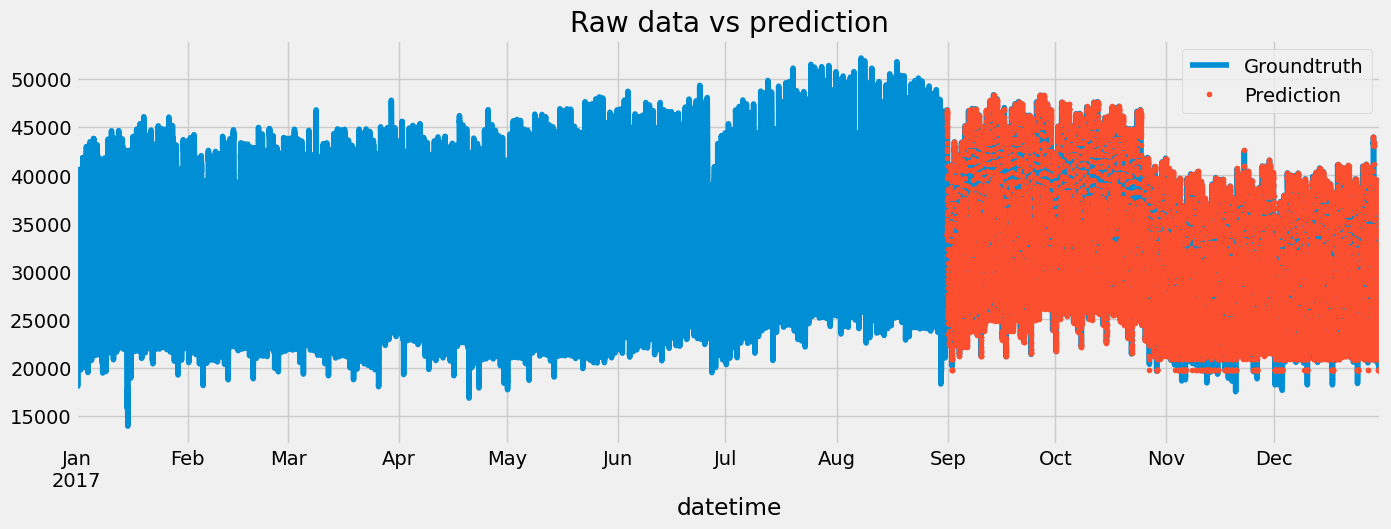

In [19]:
test['prediction'] = reg.predict(X_test)
merged = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[[target]].plot(figsize=(15, 5))

merged['prediction'].plot(ax=ax, style='.')
plt.legend(['Groundtruth', 'Prediction'])
ax.set_title('Raw data vs prediction')
plt.show()

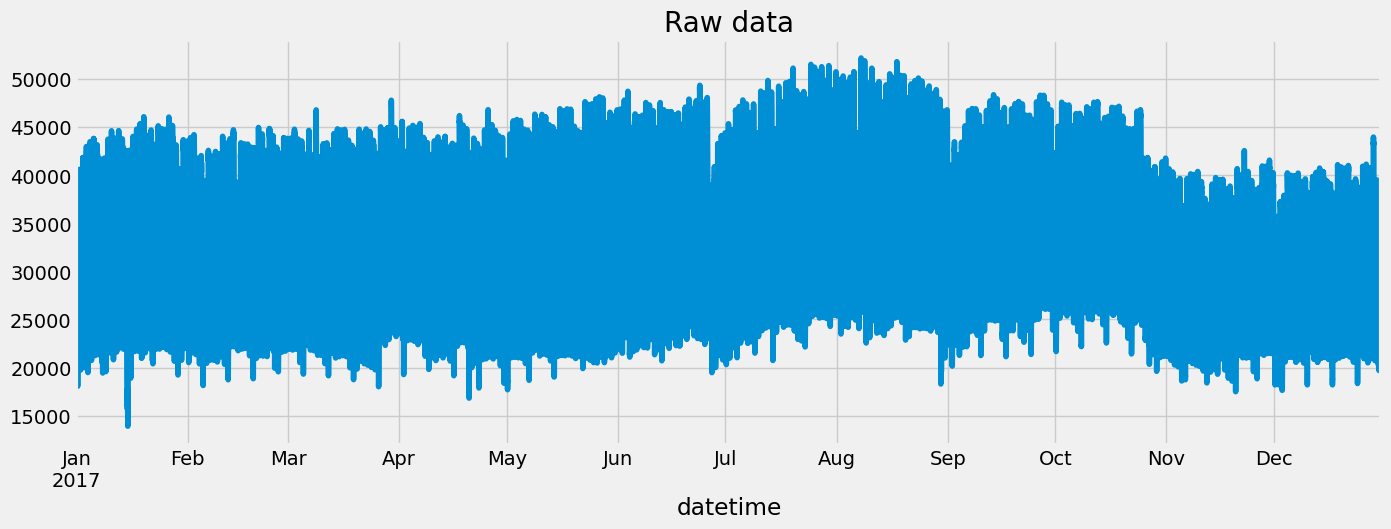

In [20]:
# To see our ground-truth clearly, seperate it to another figure
df[target].plot(figsize=(15, 5), title="Raw data")
plt.show()

## Evaluation

In [21]:
score = mean_squared_error(test[target], test['prediction'])
print(f'MSE Score on Test set: {score:0.2f}')

MSE Score on Test set: 9817.24


## Conclusion

Now, try to improve this by selecting other algorithms such as Google TFT, N-BEATs, Prophet, and TimeGPT and play around with other features such as holiday and weekday/weekend.